This notebook demonstrates how the speech embedding model from Google (https://www.kaggle.com/models/google/speech-embedding/frameworks/tensorFlow1/variations/speech-embedding/versions/1) is re-implemented in Keras manually, which can then be converted to ONNX and tflite formats for use in openWakeWord.

Note that Keras was used here, but in theory other deep learning frameworks (e.g., PyTorch) could work as well.

In [1]:
# Imports

import os
import numpy as np
import scipy
import tensorflow as tf
import tensorflow_hub as hub  # install with `pip install tensorflow_hub`
import matplotlib.pyplot as plt

2024-01-17 19:26:10.372628: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-01-17 19:26:10.372640: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Load Orignal Model from TFHub

In [2]:
# Load the original speech embedding model (now hosted on Kaggle) as a KerasLayer object

embedding_model_url = "https://tfhub.dev/google/speech_embedding/1"
embedding_model = hub.KerasLayer(embedding_model_url, trainable=False)


2024-01-17 19:26:11.857817: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-17 19:26:11.858167: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-01-17 19:26:11.858193: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2024-01-17 19:26:11.858215: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2024-01-17 19:26:11.858237: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [3]:
# Get predictions from the embedding model for a chunk of ~775 ms audio data (at 16khz)
# This is the minimum input size for the model per the documentation here: https://www.kaggle.com/models/google/speech-embedding/frameworks/tensorFlow1/variations/speech-embedding/versions/1

# Load sample clip, and select a 775 ms chunk and normalize between -1 and 1
sr, sample_data = scipy.io.wavfile.read("../tests/data/hey_mycroft_test.wav")
sample_data = (sample_data[0:12400][None,]/32767).astype(np.float32)
embeddings = embedding_model(sample_data)
print("Embedding Output Shape:", embeddings.shape)

Embedding Output Shape: (1, 1, 1, 96)


# Convert original model to tflite

In [4]:
# Build model with specific input size, and save
inputs = tf.keras.Input((12400,))
x = embedding_model(inputs)
model = tf.keras.Model(inputs=inputs, outputs=x)
model.save("google_speech_embedding_fixed_input")

speech_embedding_dir = "google_speech_embedding_fixed_input"
# speech_embedding_dir = "google_speech_embedding_savedmodel/"

converter = tf.lite.TFLiteConverter.from_saved_model(speech_embedding_dir)#, tags=["train"])
# convert = tf.lite.TFLiteConverter.from_keras_model(embedding_model)
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS
]
# converter.allow_custom_ops = True

tflite_model = converter.convert()
with open(speech_embedding_dir + '/speech_embeddings.tflite', 'wb') as f:
    f.write(tflite_model)


2024-01-17 19:26:12.970115: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: google_speech_embedding_fixed_input/assets


INFO:tensorflow:Assets written to: google_speech_embedding_fixed_input/assets
2024-01-17 19:26:14.061242: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2024-01-17 19:26:14.061261: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2024-01-17 19:26:14.061688: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: google_speech_embedding_fixed_input
2024-01-17 19:26:14.066816: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2024-01-17 19:26:14.066828: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: google_speech_embedding_fixed_input
2024-01-17 19:26:14.076781: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2024-01-17 19:26:14.173155: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: google_speech_embedding_fixed_input
2024-

# Comparing Log-Mel Features

The speech embedding model from Google computes it's own input features from raw audio, which is convenient, but not ideal as it combines pre-processing with the model in a way that makes the model less understandable. In particular, this is (to my knowledge) the total information provided about the feature creation:

From the model page [here:](https://www.kaggle.com/models/google/speech-embedding/frameworks/tensorFlow1/variations/speech-embedding/versions/1)
```
The module computes its own 32 dimensional log-mel features from the provided audio samples using the following parameters:

    stft window size: 25ms
    stft window step: 10ms
    mel band limits: 60Hz - 3800Hz
    mel frequency bins: 32
```

And then this excerpt from the corresponding [paper](https://arxiv.org/abs/2002.01322):

```
Our model is designed for deployment in an environment
where both memory and compute power are very limited,
such as on a digital signal processor (DSP). It runs on top of a
low footprint feature extractor that provides a 32 dimensional
log mel feature vector covering the frequency range from
60 Hz to 3800 Hz, quantized to 8 bits every 10 ms
```

It seems likely that this implementation is simply a [spectrogram](https://librosa.org/doc/main/generated/librosa.feature.melspectrogram.html) with [log scaling](https://librosa.org/doc/main/generated/librosa.power_to_db.html), but the investigation below shows that this may note be the case.

If you have a theory as to what the original model is doing, or why a standard log-mel spectrogram does not match, please open an issue on the [openWakeWord](https://github.com/dscripka/openWakeWord), I would love learn more about this!

INFO: Created TensorFlow Lite delegate for select TF ops.
2024-01-17 19:26:14.557849: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-17 19:26:14.558198: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
INFO: TfLiteFlexDelegate delegate: 4 nodes delegated out of 76 nodes with 2 partitions.



Embedding model features shape: (32, 76)


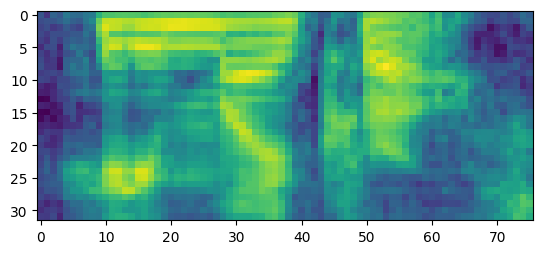

In [5]:
# Use the converted tflite model and get intermediate outputs to extract the log-mel features

interpreter = tf.lite.Interpreter(
    model_path=os.path.join(speech_embedding_dir, "speech_embeddings.tflite"),
    num_threads=1,
    experimental_preserve_all_tensors=True
)
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
interpreter.set_tensor(input_details[0]['index'], sample_data)
interpreter.invoke()

spec = interpreter.get_tensor(65)  # This index is the log-mel features, to my knowledge
spec = spec.squeeze().T  # transform for visualization
print("Embedding model features shape:", spec.shape)

_ = plt.imshow(spec)

This certainly *looks* like a log-mel spectrogram, and we can compute the same from the reference Librosa implementation for comparison.

Librosa features shape: (32, 76)


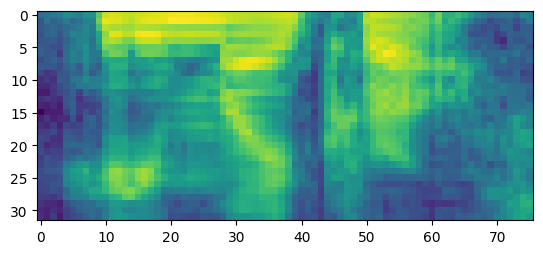

In [6]:
import librosa

S = librosa.feature.melspectrogram(y=sample_data, win_length=int(0.025*16000), 
                                   hop_length=int(0.010*16000), n_fft=512, center=True,
                                   sr=16000, n_mels=32, fmin=60, fmax=3800, power=2)#, norm=None)

S = librosa.power_to_db(S).squeeze()[:, 1:-1] # convert to logmel and remove edge columns from center=True

print("Librosa features shape:", spec.shape)
_ = plt.imshow(S)

Visually, these mel-spectrograms are very similar, but on closer inspection there are differences. Plotting at a single time slice better shows the difference:

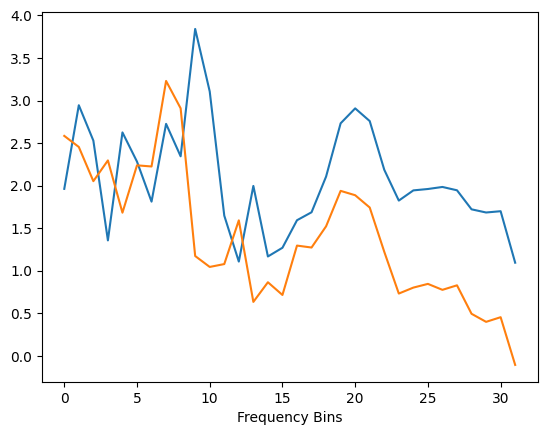

In [7]:
# Plot single time slice from both melspectrograms
_ = plt.plot(spec[:, 33])
_ = plt.plot(S[:, 33]/10 + 2)  # apply simple scalar transformation to better align the points
_ = plt.xlabel("Frequency Bins")

While the overall trend and specific frequency features are very similar between the two, they are not exact. After some time investigating this difference, eventually I moved on to other tasks with openWakeWord, and assumed that the similarity of the spectrograms would mean the downstream model performance would be relatively unnaffected. This assumption seems to have been largely true, and typically the performance difference between the openWakeWord implementation and the original Google embedding model is small.

For completeness, below is the implementation of a melspectrogram using just PyTorch, so that it can be converted to ONNX/tflite for more efficient computation on a wide range of devices. This code was based on the implementation from [torchlibrosa](https://github.com/qiuqiangkong/torchlibrosa) and is identical to the librosa reference implementation to within rounding error.

In [ ]:
# torchlibrosa version of melspectrogram

import torch
import torchlibrosa as tl
import numpy as np

batch_size = 1
sample_rate = 16000
win_length = 400
hop_length = 160
n_mels = 32
nfft=512

batch_audio = torch.empty(batch_size, 32000).uniform_(-1, 1)  # (batch_size, sample_rate)

def f(self, input):
    r"""Power to db, this function is the pytorch implementation of 
    librosa.power_to_lb.
    """
    ref_value = self.ref
    log_spec = 10.0 * torch.log(torch.clamp(input, min=self.amin, max=np.inf))/torch.log(torch.tensor(10))
    log_spec -= 10.0 * torch.log(torch.maximum(torch.tensor(self.amin), torch.tensor(ref_value)))/torch.log(torch.tensor(10))

    if self.top_db is not None:
        if self.top_db < 0:
            raise librosa.util.exceptions.ParameterError('top_db must be non-negative')
        log_spec = torch.clamp(log_spec, min=log_spec.max() - self.top_db, max=np.inf)

    return log_spec

tl.stft.LogmelFilterBank.power_to_db = f

# TorchLibrosa feature extractor the same as librosa.feature.melspectrogram()
feature_extractor = torch.nn.Sequential(
    tl.Spectrogram(
        center=False,
        n_fft=nfft,
        hop_length=hop_length,
        win_length=win_length,
    ), tl.LogmelFilterBank(
        n_fft=nfft,
        sr=sample_rate,
        n_mels=n_mels,
        fmin=60,
        fmax=3800,
        is_log=True, # Default is true
    ))

# export to onnx
torch.onnx.export(feature_extractor, batch_audio, "torchlibrosa_onnx_melspectrogram.onnx",
                  opset_version=12, input_names = ['input'], output_names = ['output'], 
                  dynamic_axes={"input": {0: 'batch_size', 1: 'samples'}, "output": {0: 'time'}})


# Create New Model with Keras

After separting the log-mel feature calculution from the embedding model, we can now re-produce the rest of the model manually in Keras.

Note that for many of the layers below, the hard-coded values and parameters were obtained by inspecting the tflite version of the original embedding model, using a tool like [Netron](http://www.netron.app).

In [8]:
# Recreate the embedding model after the melspectrogram layers
# That is, have the melspectrogram of the audio as the input instead of the raw audio

# A custom function for the leaky relu activation function, to make exporting to ONNX/tflite easier
def MyLeakyReLU(alpha = 0.20000000298023224*2):
    return lambda x : tf.keras.backend.maximum(alpha * x/2, x)

# Define convolutional block helper functions
def batch_norm_and_activation(x):
    x = tf.keras.layers.BatchNormalization()(x)
    x = MyLeakyReLU()(x)
    x = tf.maximum(x, -0.4000000059604645)
    return x

# Define contraint for zero mean conv2d layer
class CenterAround(tf.keras.constraints.Constraint):
    """Constrains weight tensors to be centered around `ref_value`."""
    def __init__(self, ref_value):
        self.ref_value = ref_value

    def __call__(self, w):
        mean = tf.reduce_mean(w, axis=(0,1))
        return w - mean + self.ref_value


# Contruct inputs
inputs = tf.keras.Input((76, 32, 1)) # melspectrogram shape when provided with 12400 samples at 16 khz

# Input conv block
x = tf.keras.layers.ZeroPadding2D((0,1))(inputs)
x = tf.keras.layers.Conv2D(24, (3,3), use_bias=False, kernel_constraint=CenterAround(0.0),
                           activation='relu', padding='valid')(x)
x = batch_norm_and_activation(x)

# Conv block #1
x = tf.keras.layers.Conv2D(24, (1,3), use_bias=False, padding='same')(x)
x = batch_norm_and_activation(x)
x = tf.keras.layers.Conv2D(24, (3,1), use_bias=False, padding='valid')(x)
x = batch_norm_and_activation(x)
x = tf.keras.layers.MaxPool2D((2,2), (2,2), padding='valid')(x)
x = tf.keras.layers.Conv2D(48, (1,3), use_bias=False, padding='same')(x)
x = batch_norm_and_activation(x)
x = tf.keras.layers.Conv2D(48, (3,1), use_bias=False, padding='valid')(x)
x = batch_norm_and_activation(x)

# Conv block #2
x = tf.keras.layers.Conv2D(48, (1,3), use_bias=False, padding='same')(x)
x = batch_norm_and_activation(x)
x = tf.keras.layers.Conv2D(48, (3,1), use_bias=False, padding='valid')(x)
x = batch_norm_and_activation(x)
x = tf.keras.layers.MaxPool2D((1,2), (1,2), padding='same')(x)
x = tf.keras.layers.Conv2D(72, (1,3), use_bias=False, padding='same')(x)
x = batch_norm_and_activation(x)
x = tf.keras.layers.Conv2D(72, (3,1), use_bias=False, padding='valid')(x)
x = batch_norm_and_activation(x)

# Conv block #3
x = tf.keras.layers.Conv2D(72, (1,3), use_bias=False, padding='same')(x)
x = batch_norm_and_activation(x)
x = tf.keras.layers.Conv2D(72, (3,1), use_bias=False, padding='valid')(x)
x = batch_norm_and_activation(x)
x = tf.keras.layers.MaxPool2D((2,2), (2,2), padding='valid')(x)
x = tf.keras.layers.Conv2D(96, (1,3), use_bias=False, padding='same')(x)
x = batch_norm_and_activation(x)
x = tf.keras.layers.Conv2D(96, (3,1), use_bias=False, padding='valid')(x)
x = batch_norm_and_activation(x)

# Conv block #4
x = tf.keras.layers.Conv2D(96, (1,3), use_bias=False, padding='same')(x)
x = batch_norm_and_activation(x)
x = tf.keras.layers.Conv2D(96, (3,1), use_bias=False, padding='valid')(x)
x = batch_norm_and_activation(x)
x = tf.keras.layers.MaxPool2D((1,2), (1,2), padding='valid')(x)
x = tf.keras.layers.Conv2D(96, (1,3), use_bias=False, padding='same')(x)
x = batch_norm_and_activation(x)
x = tf.keras.layers.Conv2D(96, (3,1), use_bias=False, padding='valid')(x)
x = batch_norm_and_activation(x)

# Conv block #5
x = tf.keras.layers.Conv2D(96, (1,3), use_bias=False, padding='same')(x)
x = batch_norm_and_activation(x)
x = tf.keras.layers.Conv2D(96, (3,1), use_bias=False, padding='valid')(x)
x = batch_norm_and_activation(x)
x = tf.keras.layers.MaxPool2D((2,2), (2,2), padding="valid")(x)
x = tf.keras.layers.Conv2D(96, (3,1), use_bias=False, padding='valid')(x)

# Build the keras model
reimplemented_model = tf.keras.Model(inputs=inputs, outputs=x)
reimplemented_model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 76, 32, 1)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 76, 34, 1)   0           ['input_2[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 32, 24)   216         ['zero_padding2d[0][0]']         
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 32, 24)  96          ['conv2d[0][0]']                 
 alization)                                                                                 

 conv2d_5 (Conv2D)              (None, 34, 16, 48)   6912        ['tf.math.maximum_9[0][0]']      
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 34, 16, 48)  192         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 tf.math.multiply_5 (TFOpLambda  (None, 34, 16, 48)  0           ['batch_normalization_5[0][0]']  
 )                                                                                                
                                                                                                  
 tf.math.truediv_5 (TFOpLambda)  (None, 34, 16, 48)  0           ['tf.math.multiply_5[0][0]']     
                                                                                                  
 tf.math.m

                                                                                                  
 batch_normalization_10 (BatchN  (None, 28, 8, 72)   288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 tf.math.multiply_10 (TFOpLambd  (None, 28, 8, 72)   0           ['batch_normalization_10[0][0]'] 
 a)                                                                                               
                                                                                                  
 tf.math.truediv_10 (TFOpLambda  (None, 28, 8, 72)   0           ['tf.math.multiply_10[0][0]']    
 )                                                                                                
                                                                                                  
 tf.math.m

 tf.math.maximum_29 (TFOpLambda  (None, 10, 4, 96)   0           ['tf.math.maximum_28[0][0]']     
 )                                                                                                
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 10, 2, 96)   0           ['tf.math.maximum_29[0][0]']     
                                                                                                  
 conv2d_15 (Conv2D)             (None, 10, 2, 96)    27648       ['max_pooling2d_3[0][0]']        
                                                                                                  
 batch_normalization_15 (BatchN  (None, 10, 2, 96)   384         ['conv2d_15[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 tf.math.m

In [9]:
# Manually set the weights of the new Keras model with those from the original embedding model

# Set weights for all layers
reimplemented_model.set_weights(embedding_model.get_weights())

# Adjust weights of specific layer that needs to be centered around 0.0
reimplemented_model.layers[2].set_weights([CenterAround(0.0)(reimplemented_model.layers[2].weights[0])])


In [ ]:
# Convert the new keras model to tflite format (optional for this notebook)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('embedding_model.tflite', 'wb') as f:
    f.write(tflite_model)

# Compare Predictions

Now that we have a re-implemented embedding model, we can verify that the predictions are the same as the original. Note that as discussed previously, the log-mel feature calculation is different, so we will start from the original audio features obtained via tflite and calculate the final embeddings from there.

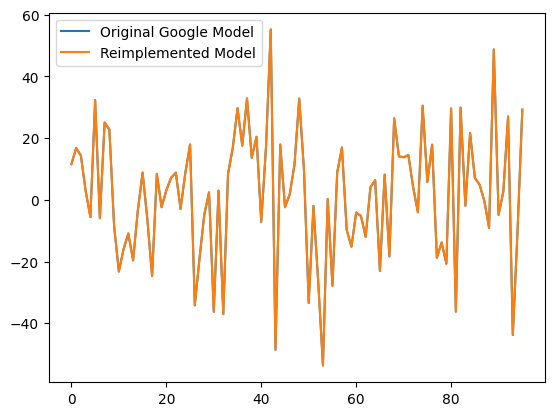

In [12]:
# Get original embedding model prediction
original_embeddings = embedding_model(sample_data)

# Reshape original log-mel inputs from tflite model above and pass to re-implemented model
reimplemented_embeddings = reimplemented_model(spec.T[None, ..., None])

# Plot final output embeddings for the sample data
_ = plt.plot(original_embeddings.numpy().flatten(), label="Original Google Model")
_ = plt.plot(reimplemented_embeddings.numpy().flatten(), label="Reimplemented Model")
_ = plt.legend()

In [13]:
# Check maximum absolute difference in the output embeddings to confirm practical equivalence
np.abs(original_embeddings.numpy().flatten() - reimplemented_embeddings.numpy().flatten()).max()

0.00010585785